# <center>MScFE690 - Capstone Project</center>




# Lab - Testing modeling and strategy development


In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import datetime
import numpy as np
import pandas as pd
import pyfolio as pf
import matplotlib.pyplot as plt
from mlfinlab.util import get_daily_vol
from mlfinlab.filters import cusum_filter
from mlfinlab.labeling import add_vertical_barrier, get_events, get_bins
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, cross_val_score
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import classification_report, r2_score
import graphviz
from datetime import datetime
import talib as ta

In [31]:
#loading dataset
df = pd.read_csv('dollar_bars.csv')
df.index = pd.to_datetime(df['date'])
df = df.drop('date', axis=1)

vol = get_daily_vol(close=df['close'], lookback=5)
cusum_events = cusum_filter(df['close'], threshold=vol['2013-09-01':'2013-09-17'].mean()*0.5)
vertical_barriers = add_vertical_barrier(t_events=cusum_events, close=df['close'], num_days=1)

pt_sl = [1, 2]
min_ret = 0.0001
triple_barrier_events = get_events(close=df['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=vol,
                                               min_ret=min_ret,
                                               num_threads=3,
                                               vertical_barrier_times=vertical_barriers)
labels = get_bins(triple_barrier_events, df['close'])
labels


2020-07-12 01:03:46.621175 100.0% apply_pt_sl_on_t1 done after 0.08 minutes. Remaining 0.0 minutes.


,ret,trgt,bin
2013-09-02 23:27:36.674,-0.002428,0.000970,-1
2013-09-03 03:06:27.897,-0.002579,0.001205,-1
2013-09-03 03:54:22.638,0.001977,0.001972,1
2013-09-03 06:05:01.276,0.002127,0.001170,1
2013-09-03 06:53:53.799,0.001825,0.001474,1
2013-09-03 07:37:17.167,0.001671,0.001202,1
2013-09-03 08:30:04.921,0.001063,0.001052,1
2013-09-03 08:31:19.100,-0.001820,0.001285,0
2013-09-03 08:32:04.887,-0.001214,0.001095,0
2013-09-03 08:33:54.061,-0.001971,0.001083,0


In [32]:
# Calculating the classical indicators for trend following
df['EMA10'] = ta.EMA(df['close'].values, timeperiod=10)
df['EMA30'] = ta.EMA(df['close'].values, timeperiod=30)
df['ATR'] = ta.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=14)
df['ADX'] = ta.ADX(df['high'].values, df['low'].values, df['close'].values, timeperiod=14)
df['RSI'] = ta.RSI(df['close'].values, timeperiod=14)
macd, macdsignal, macdhist = ta.MACD(df['close'].values, fastperiod=2, slowperiod=7, signalperiod=9)
df['MACD'] = macd
df['MACDsignal'] = macdsignal

In [33]:
df.fillna(0, inplace=True)
df.drop(['close'], axis=1)

# Log transformation
df['target'] = (df['close']-df['close'].min()+1).transform(np.log)
#  normalization
df['normalized'] = (df['close'] - df['close'].min()) / (df['close'].max() - df['close'].min())

# Calculating the columns to be used as predictors for the averages and the MACD
df['ClgtEMA10'] = np.where(df['close'] > df['EMA10'], 1, -1)
df['EMA10gtEMA30'] = np.where(df['EMA10'] > df['EMA30'], 1, -1)
df['MACDSIGgtMACD'] = np.where(df['MACDsignal'] > df['MACD'], 1, -1)
df.tail()



,open,high,low,close,volume,vwap,EMA10,EMA30,ATR,ADX,RSI,MACD,MACDsignal,target,normalized,ClgtEMA10,EMA10gtEMA30,MACDSIGgtMACD
date,,,,,,,,,,,,,,,,,,
2013-09-20 15:03:48.526,1702.00,1702.25,1701.25,1701.50,21013.0,1701.706693,1702.708289,1704.729082,1.507369,32.641567,32.552585,-0.673172,-0.456355,4.262680,0.744681,-1,-1,1
2013-09-20 15:07:25.697,1701.50,1703.00,1701.25,1702.50,20930.0,1702.346608,1702.670419,1704.585270,1.524700,32.395674,39.758227,-0.191193,-0.403322,4.276666,0.755319,-1,-1,-1
2013-09-20 15:13:47.874,1702.50,1703.25,1702.00,1703.00,20922.0,1702.831230,1702.730342,1704.482995,1.505079,31.873585,43.035169,0.169501,-0.288758,4.283587,0.760638,1,-1,-1
2013-09-20 16:01:52.808,1703.00,1704.75,1702.00,1704.75,20938.0,1703.125609,1703.097553,1704.500221,1.594002,29.864573,52.727577,0.960591,-0.038888,4.307438,0.779255,1,-1,-1
2013-09-20 16:14:59.251,1704.75,1704.75,1703.50,1703.75,2858.0,1704.222271,1703.216180,1704.451820,1.569430,27.999062,47.729964,0.581598,0.085209,4.293878,0.768617,1,-1,-1


The 3 columns added are possible trading rules that we will introduce in the decision tree to help us identify the best combination of these indicators to maximize the result.

EMA, we are interested in when the price is above average and when the fastest average is above the slowest average.
ATR(14), we’re interested in the threshold that will trigger the signal.
ADX(14), we’re interested in the threshold that will trigger the signal.

RSI(14), we’re interested in the threshold that will trigger the signal.
MACD, we are interested in when the MACD signal is above MACD.
In this example, the predictor variables for the classification decision tree and the regression decision tree will be the same, although the target variables are different because for the classification algorithm the output will be categorical and for the regression algorithm the output will be continuous.

In [34]:
# Encoding target variables
df['Return'] = df['close'].pct_change(1).shift(-1)
# Target variable for the classification decision tree
df['target_cls'] = np.where(df.Return > 0, 1, 0)
# Target variable for the future value forecast -  regression algorithm
df['target_rgs'] = df['Return']

returns = df['target']
returns.index = pd.to_datetime(returns.index)

df.tail()

,open,high,low,close,volume,vwap,EMA10,EMA30,ATR,ADX,...,MACD,MACDsignal,target,normalized,ClgtEMA10,EMA10gtEMA30,MACDSIGgtMACD,Return,target_cls,target_rgs
date,,,,,,,,,,,,,,,,,,,,,
2013-09-20 15:03:48.526,1702.00,1702.25,1701.25,1701.50,21013.0,1701.706693,1702.708289,1704.729082,1.507369,32.641567,...,-0.673172,-0.456355,4.262680,0.744681,-1,-1,1,0.000588,1,0.000588
2013-09-20 15:07:25.697,1701.50,1703.00,1701.25,1702.50,20930.0,1702.346608,1702.670419,1704.585270,1.524700,32.395674,...,-0.191193,-0.403322,4.276666,0.755319,-1,-1,-1,0.000294,1,0.000294
2013-09-20 15:13:47.874,1702.50,1703.25,1702.00,1703.00,20922.0,1702.831230,1702.730342,1704.482995,1.505079,31.873585,...,0.169501,-0.288758,4.283587,0.760638,1,-1,-1,0.001028,1,0.001028
2013-09-20 16:01:52.808,1703.00,1704.75,1702.00,1704.75,20938.0,1703.125609,1703.097553,1704.500221,1.594002,29.864573,...,0.960591,-0.038888,4.307438,0.779255,1,-1,-1,-0.000587,0,-0.000587
2013-09-20 16:14:59.251,1704.75,1704.75,1703.50,1703.75,2858.0,1704.222271,1703.216180,1704.451820,1.569430,27.999062,...,0.581598,0.085209,4.293878,0.768617,1,-1,-1,NaN,0,NaN


Given that for the regression algorithm we basically want to learn the future value based on the data available at the current time, we use the lagged return for the target variable **target_rgs**.

For the classification algorithm, we also uses the lagged return, but once the output is categorical, we must substitute it for a dummy value. If it returns positive, than we assign 1 and if it was negative, we assign 0. Also for the classification algorithm we will use  the **traintestsplit** function from sklearn modelselection library to split the dataset. 

###  Split and final data preparation - Classification Decision Tree

In [35]:
# Defining the predictos variables
predictors = ['ATR', 'ADX','RSI', 'ClgtEMA10', 'EMA10gtEMA30', 'MACDSIGgtMACD']

# Performing the split between training and testing data sets
target_cls = df.target_cls
pred_cls_train, pred_cls_test, targ_cls_train, targ_cls_test = train_test_split(df[predictors], target_cls, test_size=0.3, random_state=432, stratify=target_cls)

pred_cls_train.dropna()
pred_cls_test.dropna()
targ_cls_train.dropna()
targ_cls_test.dropna()

print (pred_cls_train.shape, targ_cls_train.shape)
print (pred_cls_test.shape, targ_cls_test.shape)

(716, 6) (716,)
(308, 6) (308,)


On this last step preparing data before applying the model, the dataset was split into train and test data sets. This was made in order to fit the model with a set of data to test the fitness of the model and avoid over-fitting. 

The train data set was created with 70% of the data from predictor and target variables data sets and the remainder 30% to test the model.

### Split and final data preparation - Regression Decision Tree

In [36]:
# 70% from the predictor dataset
train_length = int(len(df)*0.70)
df_predictors = df[predictors]
target_rgs = df.target_rgs

pred_rgs_train = df_predictors[:train_length]
pred_rgs_test = df_predictors[train_length:]
targ_rgs_train = target_rgs[:train_length]
targ_rgs_test = target_rgs[train_length:]

pred_rgs_train.replace([np.inf, -np.inf], np.nan)
pred_rgs_test.replace([np.inf, -np.inf], np.nan)
targ_rgs_train.replace([np.inf, -np.inf], np.nan)
targ_rgs_test.replace([np.inf, -np.inf], np.nan)

pred_rgs_train.fillna(0, inplace=True)
pred_rgs_test.fillna(0, inplace=True)
targ_rgs_train.fillna(0, inplace=True)
targ_rgs_test.fillna(0, inplace=True)

print (pred_rgs_train.shape, targ_rgs_train.shape)
print (pred_rgs_test.shape, targ_rgs_test.shape)

(716, 6) (716,)
(308, 6) (308,)


For regression decision tree we basically split the data at the specified rate, since the output is continuous, we don’t worry about the proportionality of the output in training and test datasets.

### Model - Classification Decision Tree

Using the **DecisionTreeClassifier** function for create the following model


In [37]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=6)

# Fitting the model
clf = clf.fit(pred_cls_train, targ_cls_train)
# Applying the prediction
targ_cls_pred = clf.predict(pred_cls_test)

In [38]:

report = classification_report(targ_cls_test, targ_cls_pred)
print(report)

              precision    recall  f1-score   support

           0       0.50      0.43      0.47       161
           1       0.46      0.53      0.49       147

   micro avg       0.48      0.48      0.48       308
   macro avg       0.48      0.48      0.48       308
weighted avg       0.48      0.48      0.48       308



Accuracy Score: 0.4805194805194805 AUC Score:0.5 Confusion Matrix: [[70 91]
 [69 78]] f1 Score: 0.48016877637130806 Precision score: 0.4825677919203099 Recall Score: 0.4826974267968057


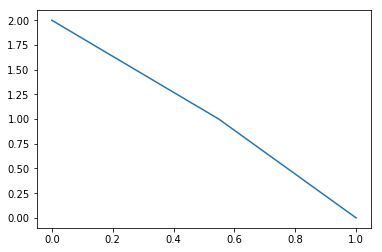

In [39]:
# Calculating Metrics for the Classification algorithm
acc_score = metrics.accuracy_score(targ_cls_test, targ_cls_pred)

auc = metrics.auc(np.sort(targ_cls_test), targ_cls_pred)
c_matrix = metrics.confusion_matrix(targ_cls_test, targ_cls_pred)
f1_score = metrics.f1_score(targ_cls_test, targ_cls_pred, average='macro')
precision = metrics.precision_score(targ_cls_test, targ_cls_pred, average='macro')
recall = metrics.recall_score(targ_cls_test, targ_cls_pred, average='macro')

fpr, tpr, threshold = metrics.roc_curve(targ_cls_test, targ_cls_pred, pos_label=2)

print(f"Accuracy Score: {acc_score}", f"AUC Score:{auc}", f"Confusion Matrix: {c_matrix}", f"f1 Score: {f1_score}",
     f"Precision score: {precision}", f"Recall Score: {recall}")

plt.plot(fpr, threshold, label='ROC curve (area = %0.3f)' % auc)

### Fund Factsheet - Classification Decision Tree

Start date,2013-09-02
End date,2013-09-20
Total months,23
,Backtest
Annual return,3.5%
Cumulative returns,6.9%
Annual volatility,3.1%
Sharpe ratio,1.11
Calmar ratio,0.82
Stability,0.79
Max drawdown,-4.2%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.23,2013-09-13,2013-09-16,2013-09-18,3
1,4.01,2013-09-05,2013-09-06,2013-09-09,3
2,3.95,2013-09-19,2013-09-20,NaT,NaN
3,2.57,2013-09-03,2013-09-03,2013-09-04,2
4,2.01,2013-09-11,2013-09-13,2013-09-13,2


Start date,2013-09-04
End date,2013-09-03
Total months,14
,Backtest
Annual return,-0.6%
Cumulative returns,-0.8%
Annual volatility,2.7%
Sharpe ratio,-0.45
Calmar ratio,-0.37
Stability,0.02
Max drawdown,-1.7%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.69,2013-09-18,2013-09-19,NaT,NaN
1,0.70,2013-09-03,2013-09-20,2013-09-10,5
2,0.19,2013-09-03,2013-09-10,2013-09-17,10
3,0.09,2013-09-05,2013-09-03,2013-09-04,0
4,0.09,2013-09-03,2013-09-05,2013-09-18,12


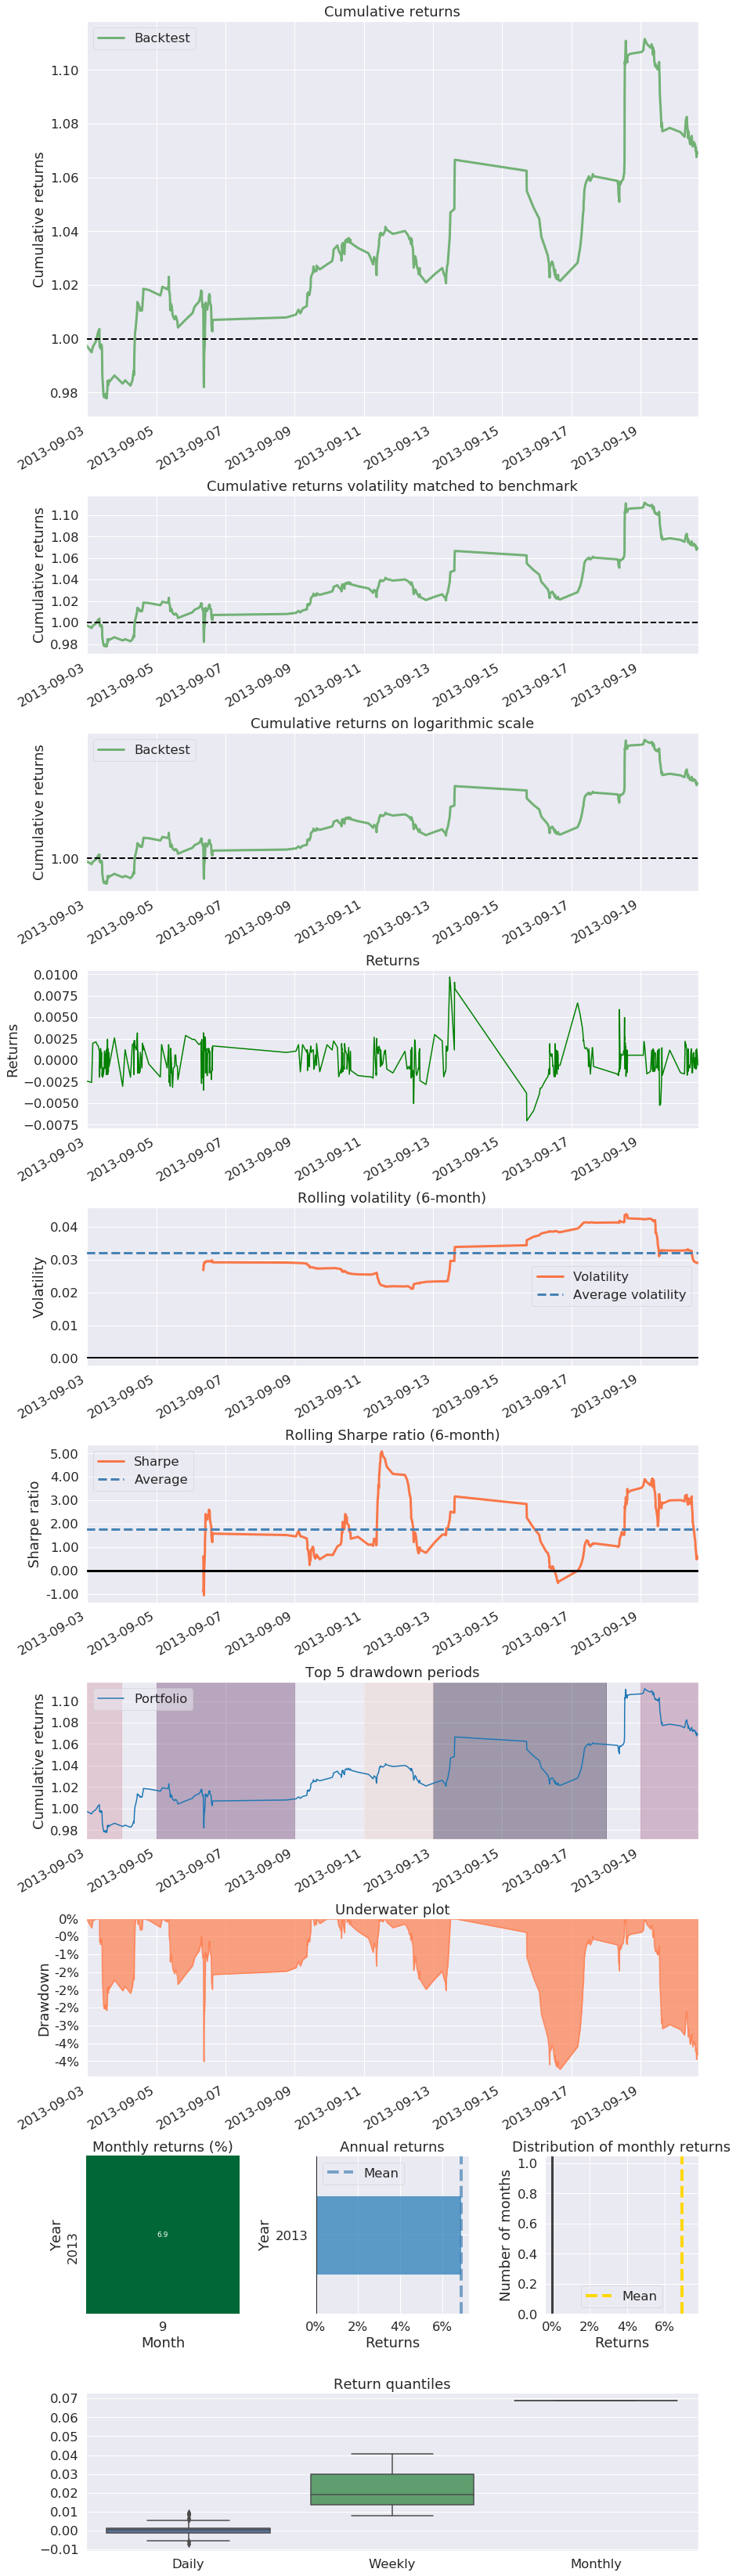

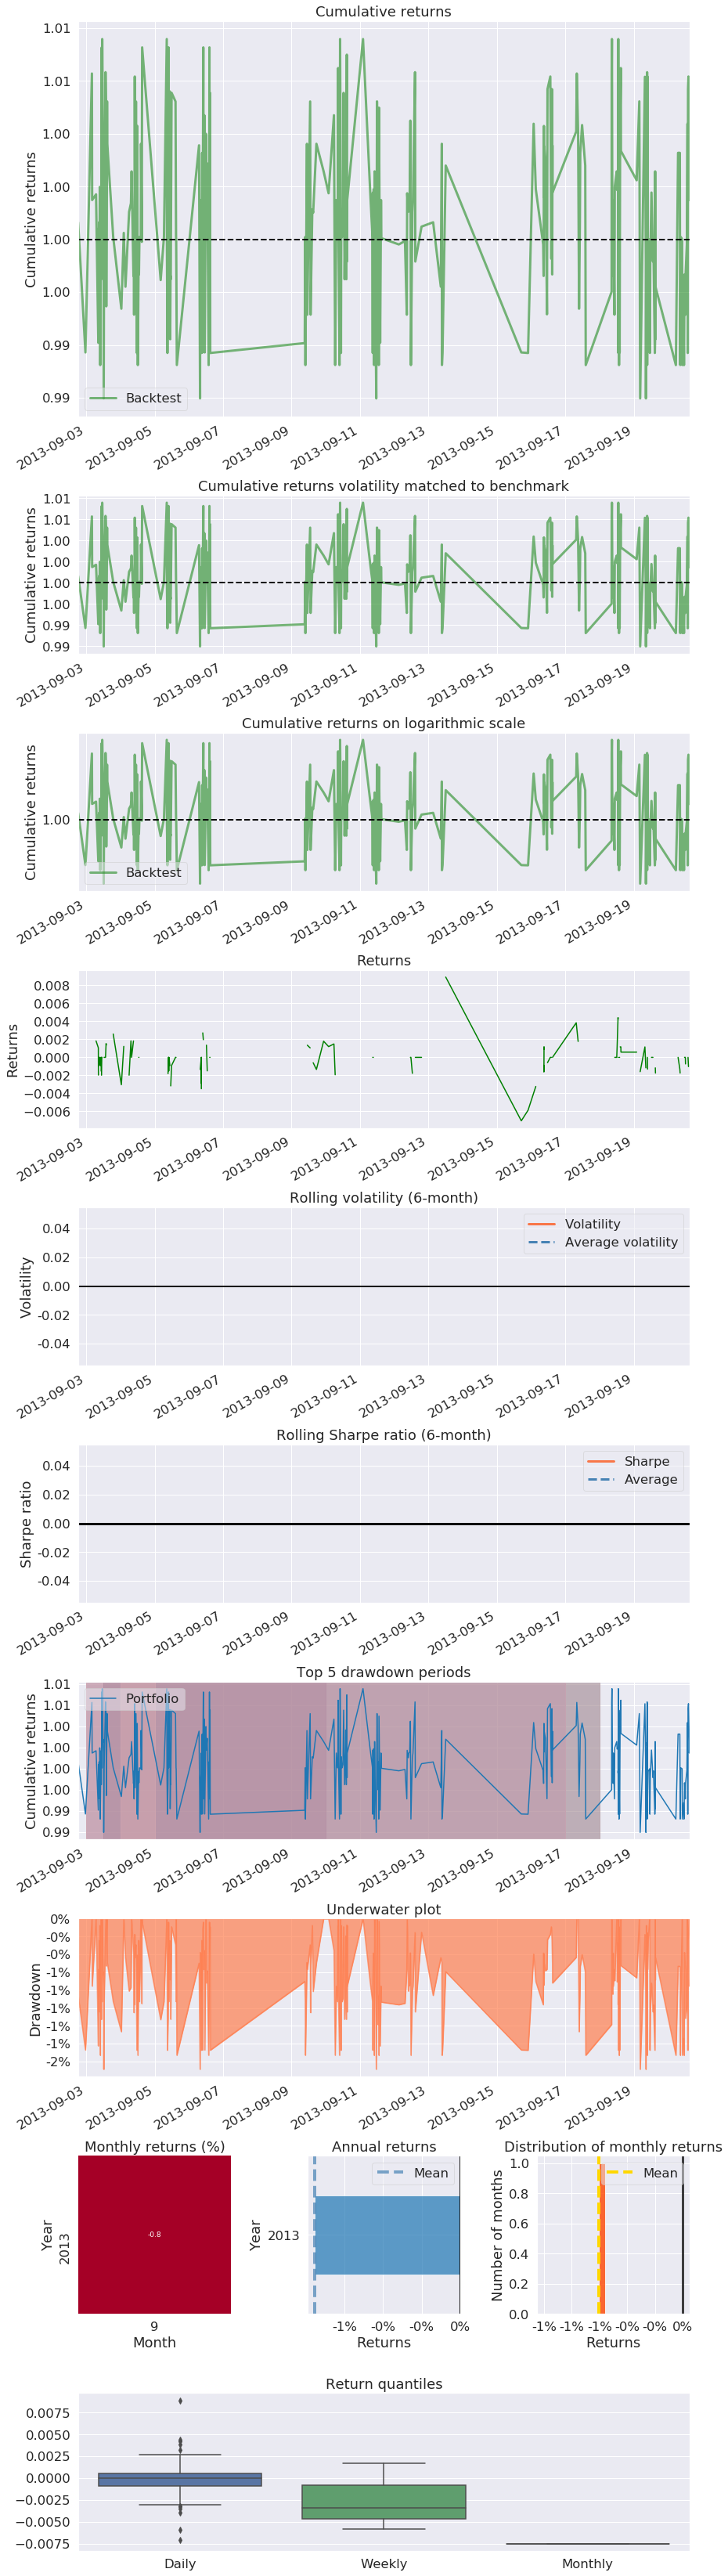

In [40]:
# Returns
pred_dates = pred_cls_test.index

#pf.plot_rolling_returns(labels['ret'])
pf.create_returns_tear_sheet(labels['ret'])

# Predicted returns
predicted = labels.loc[pred_dates, 'ret'] * targ_cls_pred

#pf.plot_rolling_returns(predicted)
pf.create_returns_tear_sheet(predicted)


### Model - Regression Decision Tree

Using the **DecisionTreeRegressor** function for create the following model


In [41]:
dtr = DecisionTreeRegressor(min_samples_leaf = 200)
dtr = dtr.fit(pred_rgs_train, targ_rgs_train)

# Applying the prediction
targ_rgs_pred = dtr.predict(pred_rgs_test)

dt_score = cross_val_score(dtr, pred_rgs_train, targ_rgs_train, cv = 5)
print("Mean cross validation score: {}".format(np.mean(dt_score)))
print("Score without cv: {}".format(dtr.score(pred_rgs_train, targ_rgs_train)))

r2 = r2_score(targ_rgs_test,targ_rgs_pred)
print("R^2 validation score: {}".format(r2))
fit_score = dtr.score(pred_rgs_test, targ_rgs_test)
print("Fitting validation score: {}".format(fit_score))

Mean cross validation score: -0.016301957298598957
Score without cv: 0.004527708573141442
R^2 validation score: -0.022058203314510028
Fitting validation score: -0.022058203314510028


### Fund Factsheet - Regression Decision Tree

Start date,2013-09-02
End date,2013-09-20
Total months,23
,Backtest
Annual return,3.5%
Cumulative returns,6.9%
Annual volatility,3.1%
Sharpe ratio,1.11
Calmar ratio,0.82
Stability,0.79
Max drawdown,-4.2%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.23,2013-09-13,2013-09-16,2013-09-18,3
1,4.01,2013-09-05,2013-09-06,2013-09-09,3
2,3.95,2013-09-19,2013-09-20,NaT,NaN
3,2.57,2013-09-03,2013-09-03,2013-09-04,2
4,2.01,2013-09-11,2013-09-13,2013-09-13,2


Start date,2013-09-16
End date,2013-09-20
Total months,14
,Backtest
Annual return,-0.0%
Cumulative returns,-0.0%
Annual volatility,0.0%
Sharpe ratio,-0.88
Calmar ratio,-0.23
Stability,0.27
Max drawdown,-0.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.00,2013-09-19,2013-09-20,NaT,NaN
1,0.00,2013-09-18,2013-09-18,2013-09-19,1
2,0.00,2013-09-18,2013-09-18,2013-09-18,1
3,0.00,2013-09-17,2013-09-17,2013-09-18,1
4,0.00,2013-09-18,2013-09-18,2013-09-18,1


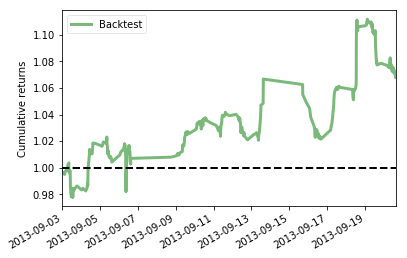

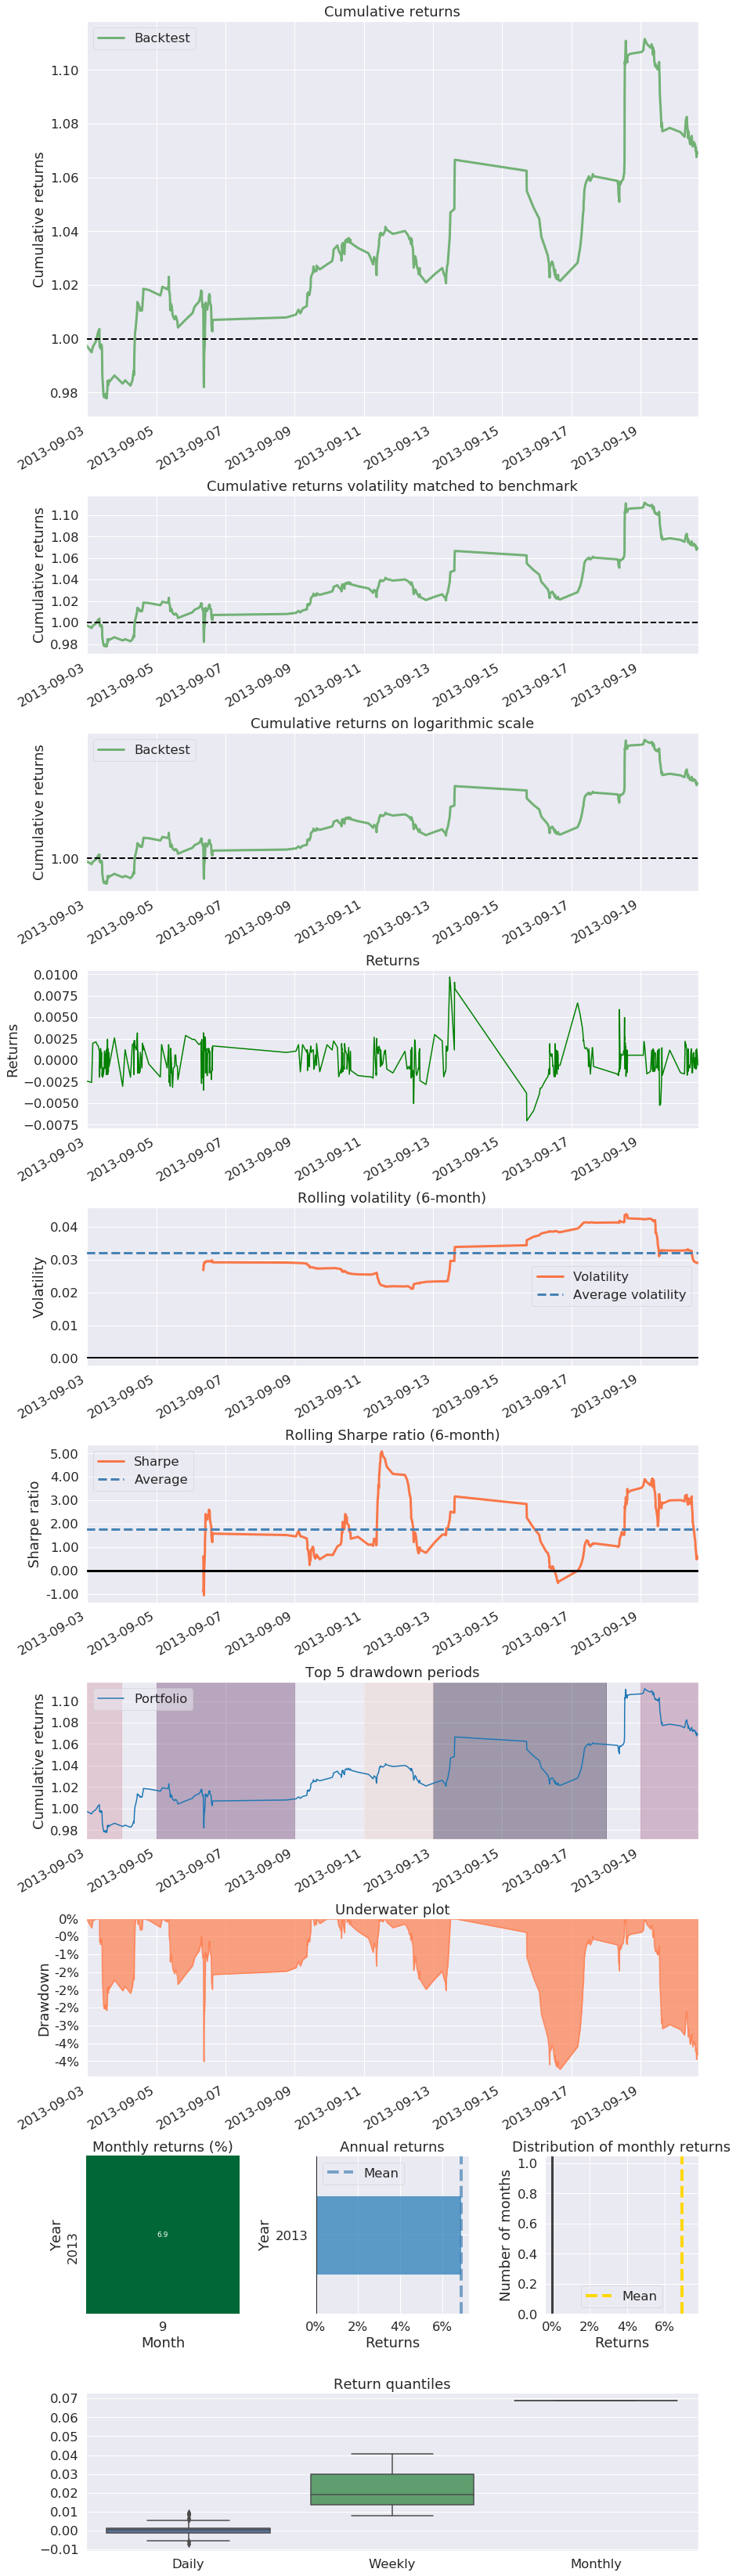

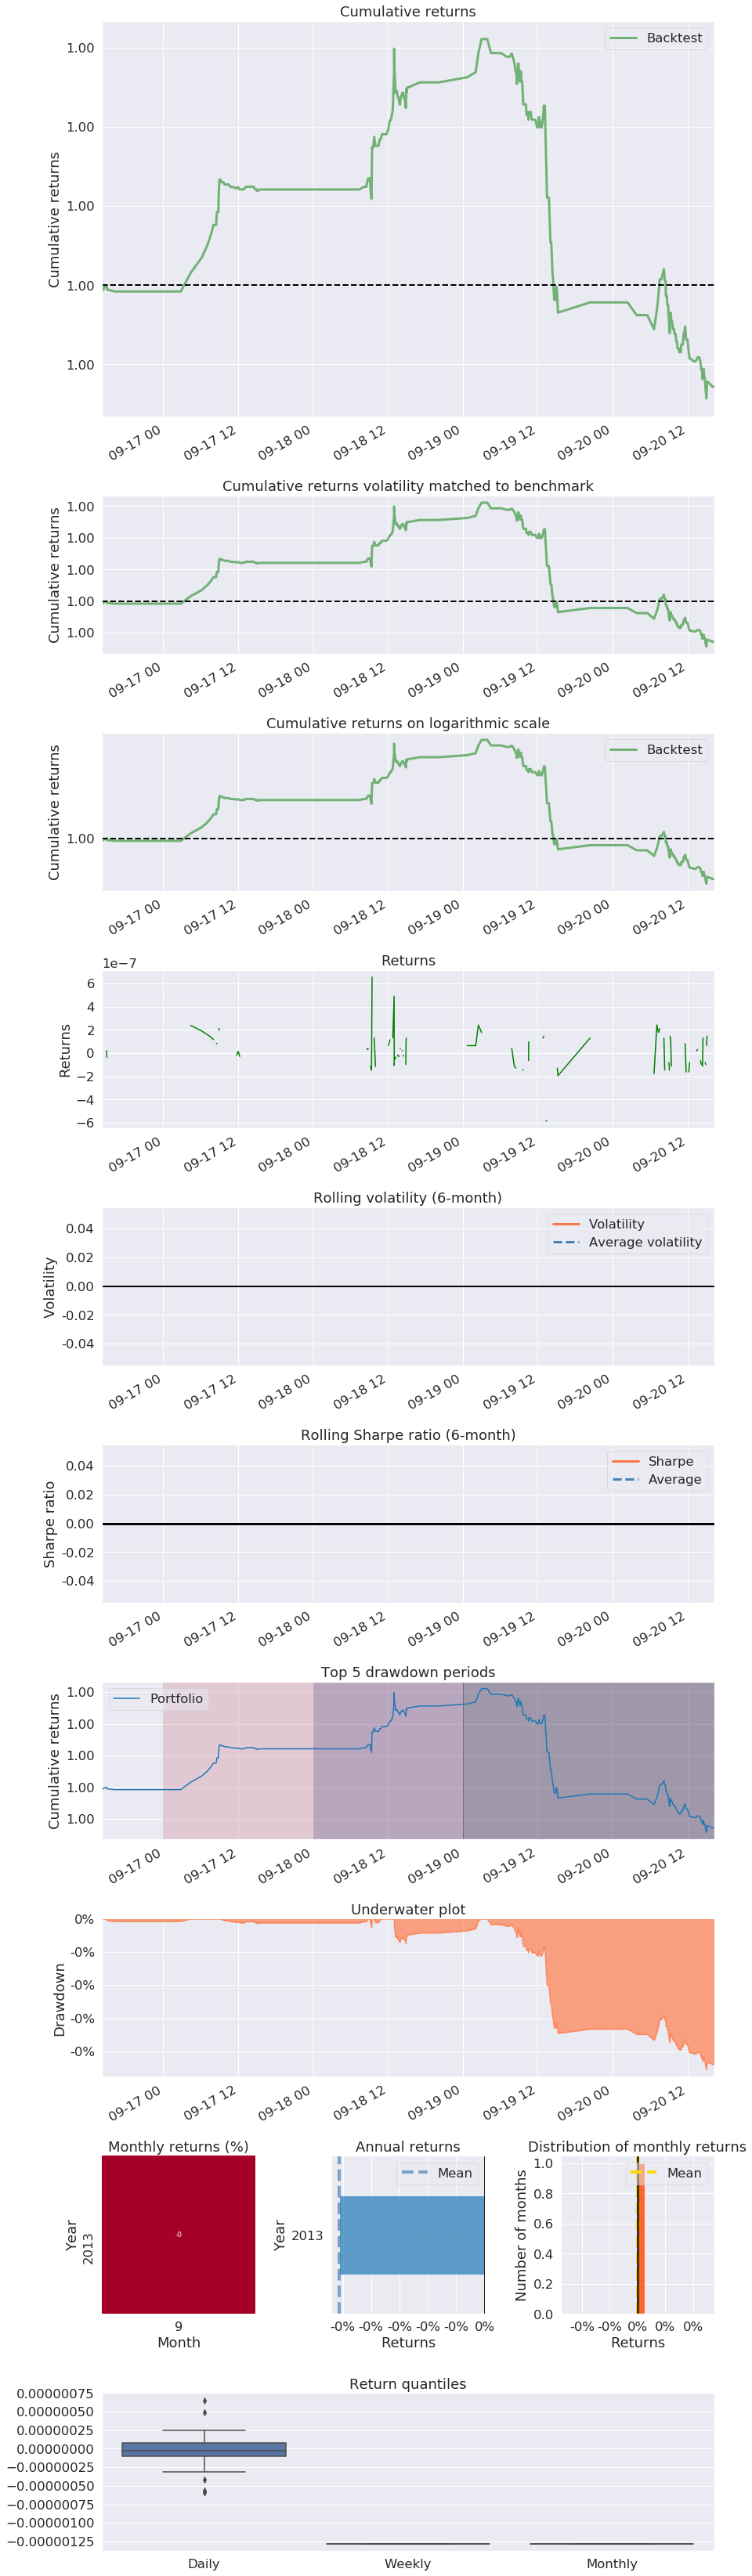

In [42]:
# Returns
pred_dates = pred_rgs_test.index

pf.plot_rolling_returns(labels['ret'])
pf.create_returns_tear_sheet(labels['ret'])

# Predicted returns
predicted = labels.loc[pred_dates, 'ret'] * targ_rgs_pred

#pf.plot_rolling_returns(predicted)
pf.create_returns_tear_sheet(predicted)
